In [93]:
# %load ../histogram_clustering.py
import pandas as pd
import numpy as np
import itertools

def generate_density_histogram(df, columns, bins):
    """ From the supplied data generates a histogram, where the value of each bin indicates how many items lay inside, in percent. I.e summing over the whole histogram yields 1.

    Parameters:
        df (DataFrame)
        columns (list of string): The column name of which the joint histogram should be created
        bins (list): See numpy.histogramdd for more information

    Returns:
        H (multidimensional nparray): The values of every bin
        edges (list of nparray): Edges of the bins in every dimension
    """

    H, edges = np.histogramdd(df[columns].values, bins=bins, density=True)

    normalization_factor = np.prod([abs(edges[i][1] - edges[i][0]) for i in range(len(bins))])
    H = H * normalization_factor
    return H, edges

# Nearest neighbour clustering
def do_BFS_step(p, clusters, current_cluster, bins, histogram_values, threshold):
    """ One step of BFS. A bin in the histogram is considered a node in the underluying graph, if its value is above a certain threshold.

    Parameters:
        p (tuple of int): Histogram coordinates of the currently expanded node
        clusters (nparray): For each bin, indicating which cluster it belongs to. -1 if none. Gets altered if the bin at p is found to be in a cluster. Same dimension as histogram.
        current_cluster (int): index of the currently searched cluster
        bins (list)
        histogram_values (nparray): Histogram values
        threshold (double): Every bin below this threshold will be discarded as noise

    Returns
        list of tuple of int: All children of p, but not necessarily nodes in the underlying graph.
    """

    result = []
    if clusters[p] >= 0 or histogram_values[p] < threshold: # Node has to be ignored. Else assign to cluster and find children.
        return result
    
    clusters[p] = current_cluster
    for i in range(len(p)):
        if p[i] > 0:
            child = list(p)
            child[i] -= 1
            result.append(tuple(child))
        if p[i] + 1 < bins[i]:
            child = list(p)
            child[i] += 1
            result.append(tuple(child))
    return result

def nearest_neighbour_clustering(histogram_values, bins, density_threshold):
    """ Searches for clusters in the given histogram, where all bins with a density below the threshold are discarded as noise. For clustering BFS is used, i.e. clusters are connected components of the underlying graph.

    Parameters:
        histogram_values (nparray): The values of every bin.
        bins (list)
        density_threshold (double): Every bin below this threshold will be discarded as noise

    Returns:
        nparray of int: For every bin in the histogram, returns which cluster it belongs to, or -1 if none.
    """

    clusters = np.ones(bins)
    clusters *= -1
    current_cluster = 0

    l = [range(b) for b in bins]
    perms = list(itertools.product(*l))
    for p in perms:
        if clusters[p] >= 0 or histogram_values[p] < density_threshold:
            continue
        
        print("Started search for cluster {}".format(current_cluster))
        nodes_to_check = do_BFS_step(p, clusters, current_cluster, bins, histogram_values, density_threshold)
        while len(nodes_to_check) > 0:
            node = nodes_to_check.pop(0)
            nodes_to_check.extend(do_BFS_step(tuple(node), clusters, current_cluster, bins, histogram_values, density_threshold))
        
        current_cluster += 1

    print("Found {} cluster(s)".format(current_cluster))
    return clusters

def create_cluster_frame(histogram_edges, histogram_values, bins, clusters, columns, cluster_column_name='CLUSTER'): 
    """ Constructs a Data Frame from a histogram and cluster results

    Parameters:
        histogram_edges (list of nparray): Edges of the bins in every dimension
        histogram_values (nparray): The values of every bin.
        bins (list)
        clusters (list of int): cluster, to which every bin belongs to
        columns (list of string): column names of clustered data
        cluster_column_name (string): column name of the cluster result
    """
    
    l = [range(b) for b in bins]
    perms = list(itertools.product(*l))
    values = [[(histogram_edges[i][perm[i]] + histogram_edges[i][perm[i]+1])*0.5 for i in range(len(bins))] + [histogram_values[perm], clusters[perm]] for perm in perms]
    clustered = pd.DataFrame(values, columns=columns + ['DENSITY', cluster_column_name])
    return clustered

In [107]:
# %load ../load_data.py
import pandas as pd

def read_data_from_csv(filename, cols_to_read, rows_to_read):
    """ Read a csv file into a DataFrame

    Parameters:
        filename (string): Filename
        cols_to_read (list of string): The column names to read, None if everything should be read
        rows_to_read (list of int): The rown numbers to read, None if everything should be read

    Returns:
        DataFrame
    """

    print("Loading data from csv file \'{}\'".format(filename))
    if cols_to_read is None:
        df = pd.read_csv(filename).fillna(method='ffill')
    else:
        df = pd.read_csv(filename, usecols=cols_to_read).fillna(method='ffill')

    if rows_to_read is None:
        return df
    else:
        return df.iloc[rows_to_read]

def convert_column(df, column, type):
    """ Converts the dtype of a column

    Parameters:
        df (DataFrame): The DataFrame containing the column
        column (string): The column name
        type (string): dtype the column should be converted to

    Returns:
        DataFrame: The altered DataFrame or the old one, if it did not contain the specified column
    """

    if column in df.columns:
        print("Converting column \'{}\' to \'{}\'".format(column, type))
        return df.astype({column:type})
    else:
        print("Column \'{}\' does not exist".format(column))
        return df

def convert_column_types(df):
    """ Convert all columns of a Dataframe of measurements to single precision values.

    Parameters:
        df (DataFrame): DataFrame to be altered

    Returns:
        DataFrame
    """

    print("Started type conversion of columns...")
    df = convert_column(df, 'IP.NSRCGEN:BIASDISCAQNV', 'float32')
    df = convert_column(df, 'IP.NSRCGEN:GASSASAQN', 'float32')
    df = convert_column(df, 'IP.NSRCGEN:SOURCEHTAQNI', 'float32')
    df = convert_column(df, 'IP.SAIREM2:FORWARDPOWER', 'float32')
    df = convert_column(df, 'SOLCEN.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'IP.SOLEXT.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'IP.SOLINJ.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'ITF.BCT15:CURRENT', 'float32')
    df = convert_column(df, 'ITF.BCT25:CURRENT', 'float32')
    df = convert_column(df, 'ITH.BCT41:CURRENT', 'float32')
    df = convert_column(df, 'ITL.BCT05:CURRENT', 'float32')
    return df


def clean_data(df):
    """ Clean the data of measurements, that are outliers, e.g. spikes in the extraction current.

    Parameters:
        df (DataFrame): DataFrame containing the measurements.

    Returns:
        DataFrame: Cleaned data.
    """

    print("Filtering data...")
    df.dropna(inplace=True)
    if 'IP.NSRCGEN:BIASDISCAQNV' in df.columns:
        df.drop(df[df['IP.NSRCGEN:BIASDISCAQNV'] > -10].index, inplace=True)
    if 'ITF.BCT15:CURRENT' in df.columns:
        df.drop(df[df['ITF.BCT15:CURRENT'] < 0].index, inplace=True)
    if 'ITF.BCT25:CURRENT' in df.columns:
        df.drop(df[df['ITF.BCT25:CURRENT'] < 0].index, inplace=True)
    if 'ITH.BCT41:CURRENT' in df.columns:
        df.drop(df[df['ITH.BCT41:CURRENT'] < 0].index, inplace=True)
    if 'ITL.BCT05:CURRENT' in df.columns:
        df.drop(df[df['ITL.BCT05:CURRENT'] < 0].index, inplace=True)
    if 'IP.NSRCGEN:OVEN1AQNP' in df.columns:
        df.drop(df[df['IP.NSRCGEN:OVEN1AQNP'] < 4.5].index, inplace=True)
    if 'IP.SOLEXT.ACQUISITION:CURRENT' in df.columns:
        df.drop(df[df['IP.SOLEXT.ACQUISITION:CURRENT'] < 1200].index, inplace=True)
    if 'IP.SAIREM2:FORWARDPOWER' in df.columns:
        df.drop(df[df['IP.SAIREM2:FORWARDPOWER'] < 500].index, inplace=True)
    if 'IP.NSRCGEN:SOURCEHTAQNI' in df.columns:
        df.drop(df[df['IP.NSRCGEN:SOURCEHTAQNI'] > 2.5].index, inplace=True)
    if 'IP.NSRCGEN:SOURCEHTAQNI' in df.columns:
        df.drop(df[df['IP.NSRCGEN:SOURCEHTAQNI'] < 0.5].index, inplace=True)
    
    return df

### Multivariate normal that streches in the x and y directions

In [94]:
mean = [0,0,0]
cov = [[10, 0, 0], [0, 10, 0], [0, 0, 0.1]]
x, y, z = np.random.multivariate_normal(mean, cov, 250000).T
df = pd.DataFrame({'X':x, 'Y':y, 'Z':z})

### Two multivariate normals
One streching in x and y direction, and in y and z direction with an offset mean in z direction

In [18]:
mean1 = [0,0,0]
cov1 = [[10, 0, 0], [0, 10, 0], [0, 0, 0.1]]
x1, y1, z1 = np.random.multivariate_normal(mean1, cov1, 250000).T

In [47]:
mean2 = [0,0,10]
cov2 = [[0.1, 0, 0], [0, 5, 0], [0, 0, 5]]
x2, y2, z2 = np.random.multivariate_normal(mean2, cov2, 250000).T

In [48]:
df = pd.DataFrame({'X':np.concatenate((x1, x2)), 'Y':np.concatenate((y1, y2)), 'Z': np.concatenate((z1, z2))})
df.shape

(500000, 3)

### Two multivariate normals without offset
One streching in x and y direction, and in y and z direction, both with mean 0

In [53]:
mean1 = [0,0,0]
cov1 = [[10, 0, 0], [0, 10, 0], [0, 0, 0.1]]
x1, y1, z1 = np.random.multivariate_normal(mean1, cov1, 250000).T

In [54]:
mean2 = [0,0,0]
cov2 = [[0.1, 0, 0], [0, 5, 0], [0, 0, 5]]
x2, y2, z2 = np.random.multivariate_normal(mean2, cov2, 250000).T

In [55]:
df = pd.DataFrame({'X':np.concatenate((x1, x2)), 'Y':np.concatenate((y1, y2)), 'Z': np.concatenate((z1, z2))})
df.shape

(500000, 3)

### Multivariate normal with non diagonal covariance matrix

In [66]:
mean = [0,0,0]
cov = [[2.5, 1, 0], [1, 5, 0], [0, 0, 1]]
x, y, z = np.random.multivariate_normal(mean, cov, 250000).T

In [68]:
df = pd.DataFrame({'X':x, 'Y':y, 'Z':z})
df.shape

(250000, 3)

### Real Source Data
#### BiasDisc vs Gas

In [108]:
df = read_data_from_csv('../Data_Raw/Nov2018.csv', ['IP.NSRCGEN:BIASDISCAQNV', 'IP.NSRCGEN:GASSASAQN'], None)
df = convert_column_types(df)
df = clean_data(df)
df.columns = ['X', 'Y']
df.shape

Loading data from csv file '../Data_Raw/Nov2018.csv'
Started type conversion of columns...
Converting column 'IP.NSRCGEN:BIASDISCAQNV' to 'float32'
Converting column 'IP.NSRCGEN:GASSASAQN' to 'float32'
Column 'IP.NSRCGEN:SOURCEHTAQNI' does not exist
Column 'IP.SAIREM2:FORWARDPOWER' does not exist
Column 'SOLCEN.ACQUISITION:CURRENT' does not exist
Column 'IP.SOLEXT.ACQUISITION:CURRENT' does not exist
Column 'IP.SOLINJ.ACQUISITION:CURRENT' does not exist
Column 'ITF.BCT15:CURRENT' does not exist
Column 'ITF.BCT25:CURRENT' does not exist
Column 'ITH.BCT41:CURRENT' does not exist
Column 'ITL.BCT05:CURRENT' does not exist
Filtering data...


(2845267, 2)

#### BiasDisc vs Oven

In [119]:
df = read_data_from_csv('../Data_Raw/Nov2018.csv', ['IP.NSRCGEN:BIASDISCAQNV', 'IP.NSRCGEN:OVEN1AQNP'], None)
df = convert_column_types(df)
df = clean_data(df)
df.columns = ['X', 'Y']
df.shape

Loading data from csv file '../Data_Raw/Nov2018.csv'
Started type conversion of columns...
Converting column 'IP.NSRCGEN:BIASDISCAQNV' to 'float32'
Column 'IP.NSRCGEN:GASSASAQN' does not exist
Column 'IP.NSRCGEN:SOURCEHTAQNI' does not exist
Column 'IP.SAIREM2:FORWARDPOWER' does not exist
Column 'SOLCEN.ACQUISITION:CURRENT' does not exist
Column 'IP.SOLEXT.ACQUISITION:CURRENT' does not exist
Column 'IP.SOLINJ.ACQUISITION:CURRENT' does not exist
Column 'ITF.BCT15:CURRENT' does not exist
Column 'ITF.BCT25:CURRENT' does not exist
Column 'ITH.BCT41:CURRENT' does not exist
Column 'ITL.BCT05:CURRENT' does not exist
Filtering data...


(2821239, 2)

### Plotting the sample data
#### 2D Plot

In [146]:
bins = [10, 10] 
cols_to_cluster = ['X', 'Y']
H, edges = generate_density_histogram(df, cols_to_cluster, bins)

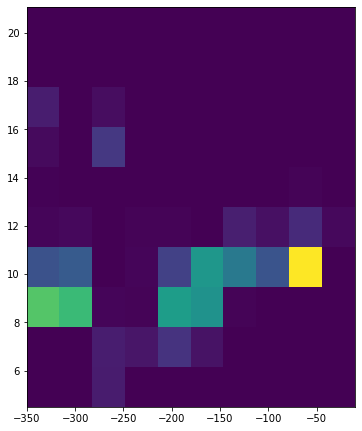

In [147]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (20,20)


fig = plt.figure()
ax = fig.add_subplot(132)
ax.set_aspect('25')
X, Y = np.meshgrid(edges[0], edges[1])
ax.pcolormesh(X, Y, H)

plt.show()

In [153]:
cl_df

,X,Y,DENSITY,CLUSTER
0,-333.0,5.33535,0.000000,-1.0
1,-333.0,6.99205,0.000004,-1.0
2,-333.0,8.64875,0.011624,0.0
3,-333.0,10.30545,0.000000,-1.0
4,-333.0,11.96215,0.000000,-1.0
5,-333.0,13.61885,0.000000,-1.0
6,-333.0,15.27555,0.000000,-1.0
7,-333.0,16.93225,0.000005,-1.0
8,-333.0,18.58895,0.000000,-1.0
9,-333.0,20.24565,0.000000,-1.0


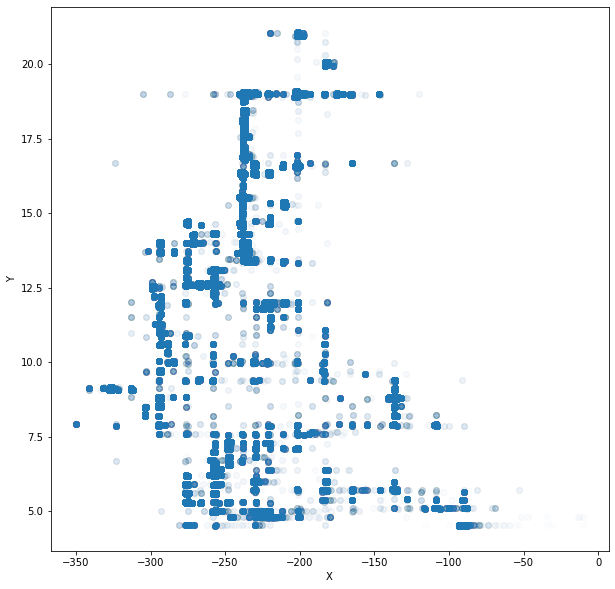

In [125]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(df['X'], df['Y'], marker='o', alpha=0.01)

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

#### 3D Plot

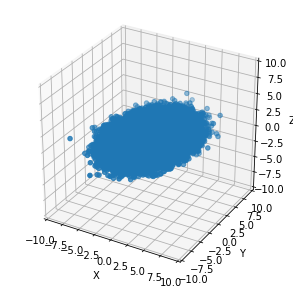

In [80]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (10,10)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['X'], df['Y'], df['Z'], marker='o')

ax.set_xlabel('X')
ax.set_xlim(-10, 10)
ax.set_ylabel('Y')
ax.set_ylim(-10, 10)
ax.set_zlabel('Z')
ax.set_zlim(-10, 10)

plt.show()

### Clustering using Nearest Neighbour Clustering

In [148]:
hist_mean = np.mean(H)
hist_std = np.std(H)
threshold = hist_mean
threshold

0.009999999999999998

In [151]:
clusters = nearest_neighbour_clustering(H, bins, threshold)
cl_df = create_cluster_frame(edges, H, bins, clusters, cols_to_cluster)

Started search for cluster 0
Started search for cluster 1
Started search for cluster 2
Started search for cluster 3
Started search for cluster 4
Found 5 cluster(s)


In [150]:
pd.set_option('display.max_columns', 500)
cl_df = cl_df.groupby('CLUSTER').describe()
cl_df[('DENSITY', 'total')] = cl_df[('DENSITY', 'count')] * cl_df[('DENSITY', 'mean')]
cl_df.sort_values([('DENSITY', 'total')], ascending=0)

X                                                               Y  \
        count       mean         std    min    25%    50%    75%    max count   
CLUSTER                                                                         
 1.0     10.0 -237.80000   31.243844 -299.0 -256.5 -231.0 -231.0 -197.0  10.0   
 2.0      4.0 -248.00000   19.629909 -265.0 -265.0 -248.0 -231.0 -231.0   4.0   
-1.0     82.0 -167.97561  101.385583 -333.0 -265.0 -163.0  -95.0  -27.0  82.0   
 3.0      1.0 -129.00000         NaN -129.0 -129.0 -129.0 -129.0 -129.0   1.0   
 0.0      2.0 -316.00000   24.041631 -333.0 -324.5 -316.0 -307.5 -299.0   2.0   
 4.0      1.0  -95.00000         NaN  -95.0  -95.0  -95.0  -95.0  -95.0   1.0   

                                                                        \
              mean       std       min        25%       50%        75%   
CLUSTER                                                                  
 1.0     14.778540  2.596084  11.96215  12.376325  14.44720  16.518075   
 2.0      6.163700  0.956496   5.33535   5.335350   6.16370   6.992050   
-1.0     13.113759  4.805023   5.33535   8.648750  13.61885  16.932250   
 3.0      8.648750       NaN   8.64875   8.648750   8.64875   8.648750   
 0.0      8.648750  0.000000   8.64875   8.648750   8.64875   8.648750   
 4.0      5.335350       NaN   5.33535   5.335350   5.33535   5.335350   

                  DENSITY                                                    \
              max   count      mean       std       min       25%       50%   
CLUSTER                                                                       
 1.0     18.58895    10.0  0.058458  0.043247  0.013169  0.024319  0.051064   
 2.0      6.99205     4.0  0.074894  0.038961  0.038853  0.042572  0.074013   
-1.0     20.24565    82.0  0.000666  0.001641  0.000000  0.000000  0.000000   
 3.0      8.64875     1.0  0.025058       NaN  0.025058  0.025058  0.025058   
 0.0      8.64875     2.0  0.012054  0.000607  0.011624  0.011839  0.012054   
 4.0      5.33535     1.0  0.012045       NaN  0.012045  0.012045  0.012045   

                                       
              75%       max     total  
CLUSTER                                
 1.0     0.080633  0.153807  0.584578  
 2.0     0.106335  0.112697  0.299575  
-1.0     0.000107  0.008637  0.054635  
 3.0     0.025058  0.025058  0.025058  
 0.0     0.012268  0.012483  0.024107  
 4.0     0.012045  0.012045  0.012045